In [ ]:
# default_exp plots

# Plots

> This module defines functions for plotting the ridge reliability and confidence reliability diagrams. Both types of diagrams can be plotted with one figure per class (class-wise) or one aggregated figure for the classifier.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export

from ridgereliability import utils, metrics as rmetrics

import matplotlib.pyplot as plt
import matplotlib.axes
from matplotlib import gridspec, cm

import numpy as np
from scipy.stats import beta
from ridgereliability.beta import get_beta_parameters, beta_avg_pdf

import sklearn.datasets
import sklearn.model_selection
import sklearn.svm
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize

In [ ]:
# exporti

def _decorate_ax(ax:matplotlib.axes.Axes):
    """Apply cosmetic changes to a matplotlib axis.

    Arguments:
    ax -- matplotlib axis
    """

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.setp(ax.spines.values(), color=cm.tab20c(18))
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=cm.tab20c(18))
    
def _get_beta_pdf(dist):
    if len(dist) == 2:
        # dist contains the parameters of the beta distribution
        a, b = dist

        # sample the beta
        x = np.linspace(0, 1, 500)
        pdf = beta.pdf(x, a, b)
    else:
        # dist contains samples of the beta pdf

        ## sample from the beta distribution using the pdf probabilities

        # make it impossible to sample 0 or 1
        # in theory this should never happen, but approximations introduce errors
        dist[0] = 0.0
        dist[-1] = 0.0

        x = np.linspace(0, 1, len(dist))
        samples = np.random.choice(x, size=500, p=dist/dist.sum())

        ## fit a beta distribution to the samples
        a, b, loc, scale = beta.fit(samples, floc=0, fscale=1)

        pdf = dist
        
    return a, b, pdf, x
    
class clipped_cm:
        def __init__(self, n, base_cm=cm.Greys, clip_range=(0.5, 1.0)):
            self.n = n
            self.space = np.linspace(*clip_range, n+1)
            self.cm = [base_cm(p) for p in self.space]

        def __call__(self, x):
            return self.cm[int(x*self.n)]

## Probabilistic classification: toy example

In [ ]:
np.random.seed(42)

In [ ]:
X, y = sklearn.datasets.make_classification(n_samples=5000, n_features=12, n_informative=3, n_classes=3)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
logreg = sklearn.svm.SVC(probability=True)

In [ ]:
logreg.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
y_probs = logreg.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_probs.argmax(axis=1))}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_probs.argmax(axis=1))}")

Accuracy: 0.808
Balanced accuracy: 0.8084048918146675


## Ridge reliability diagram

In [ ]:
# exporti

def ridge_diagram(beta_distributions_per_bin:np.array, proportions_per_bin:np.array, ax:matplotlib.axes.Axes, ci:float=0.95):

    _decorate_ax(ax)

    cmap = clipped_cm(len(proportions_per_bin))

    y_max = 1+1/(len(beta_distributions_per_bin)/1.5)
    ax.set_ylim(0, y_max)
    ax.spines["left"].set_bounds(low=0., high=1.0)

    ax.plot([0,1], [0,1], color=cm.tab20c(19), zorder=0)

    for i, (proportion, dist) in enumerate(zip(proportions_per_bin, beta_distributions_per_bin)):
        n_layers = 4
        layer = [len(proportions_per_bin)*n_layers+1 - (n_layers*i)+n for n in range(n_layers)]

        if proportion is np.nan:
            continue
            
        a, b, pdf, x = _get_beta_pdf(dist)

        interval = beta.interval(ci, a, b)
        dist_mean = a/(a+b)

        # rescale it to 0-x range
        pdf /= pdf.max()
        pdf /= len(proportions_per_bin)/1.5

        # plot full distribution
        ax.plot(x, pdf+proportion, lw=1, linestyle="dotted", color=cmap(1-proportion), zorder=layer[1])

        # plot confidence interval
        idx = [j for j,p in enumerate(x) if interval[0] <= p <= interval[1]]
        ax.plot(x[idx], pdf[idx]+proportion, 'r-', lw=1.5, color=cmap(1-proportion), zorder=layer[3], clip_on=False)
        ax.plot(x[idx], pdf[idx]+proportion, 'r-', lw=5, color="white", zorder=layer[2], clip_on=False)

        # plot extra marker at distribution mode
        ax.scatter(dist_mean, proportion, color=cmap(1-proportion), edgecolor="white", linewidth=2, s=25, zorder=layer[2])

In [ ]:
# exporti

def river_diagram(beta_distributions_per_bin:np.array, proportions_per_bin:np.array, ax:matplotlib.axes.Axes, ci=[0.90, 0.95, 0.99]):
    
    ci = sorted(ci)[::-1]

    _decorate_ax(ax)

    ax.set_ylim(0, 1)

    intervals = np.empty((len(proportions_per_bin), len(ci), 2), dtype=float)
    means = np.empty((len(proportions_per_bin),), dtype=float)
    for i, (proportion, dist) in enumerate(zip(proportions_per_bin, beta_distributions_per_bin)):
        if proportion is np.nan:
            continue

        a, b, pdf, _ = _get_beta_pdf(dist)

        for j, l in enumerate(ci):
            intervals[i, j] = beta.interval(l, a, b)
        means[i] = a/(a+b)
        
    for i, l in enumerate(ci):
        ax.fill_between(proportions_per_bin, intervals[:, i, 0], intervals[:, i, 1], zorder=i, color=cm.Greys(0.2+i*0.1), label=f"{int(l*100):2d}% CI")
    ax.plot(proportions_per_bin, means, ".-", ms=10, color="black", zorder=4, label="Mean")
    ax.plot([0,1], [0,1], color=cm.Greys(0.8), linestyle="--", zorder=5, label="Perfect calibration")

In [ ]:
# export

def posterior_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, ax:matplotlib.axes.Axes=None, bins="fd", style:str="river", exact:bool=False, ci=None):

    assert "Unknown style", style in ["river", "ridge"]
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw={"aspect": 0.75}, dpi=100, tight_layout=True)

    num_classes = len(np.unique(y_true))

    bin_indices, edges = utils.get_bin_indices(y_probs, bins, 0.0, 1.0, return_edges=True)
    unique_bin_indices = sorted(np.unique(bin_indices))

    proportions = np.empty((len(unique_bin_indices),), dtype=np.float32) # store mean confidence

    if not exact:
        n_samples = 10000
        distributions = np.empty((len(unique_bin_indices), n_samples), dtype=np.float32) # store beta parameters
        x = np.linspace(0, 1, n_samples)
    else:
        distributions = np.empty((len(unique_bin_indices), 2), dtype=np.int)

    # compute beta distributions per bin per class
    for i, bin_idx in enumerate(unique_bin_indices):
        selector = bin_indices == bin_idx

        proportions[i] = y_probs[selector].mean()

        if not exact:
            conf = confusion_matrix(y_true[selector], y_preds[selector], labels=np.arange(0, num_classes))
            parameters = get_beta_parameters(conf)
            distributions[i] = beta_avg_pdf(x, parameters)
        else:
            correct = (y_true[selector] == y_preds[selector]).sum()
            incorrect = len(y_true[selector]) - correct
            distributions[i] = correct + 1, incorrect + 1

    if style == "river":
        ax.set_xlabel("Confidence level")
        ax.set_ylabel("Posterior balanced accuracy")
        if isinstance(ci, list):
            river_diagram(distributions, proportions, ax, ci=ci)
        else:
            river_diagram(distributions, proportions, ax)
    elif style == "ridge":
        ax.set_ylabel("Confidence level")
        ax.set_xlabel("Posterior balanced accuracy")
        if ci is not None:
            ridge_diagram(distributions, proportions, ax, ci=ci)
        else:
            ridge_diagram(distributions, proportions, ax)
                
    return ax


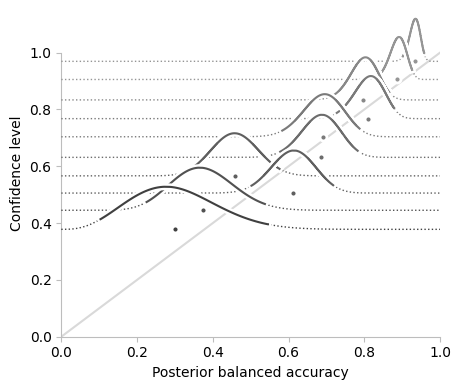

In [ ]:
posterior_reliability_diagram(y_probs.max(axis=1), y_probs.argmax(axis=1), y_test, style="ridge", bins=15)

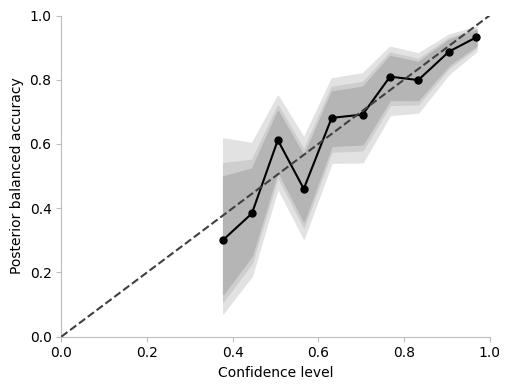

In [ ]:
posterior_reliability_diagram(y_probs.max(axis=1), y_probs.argmax(axis=1), y_test, style="river", bins=15)

In [ ]:
# export

def class_wise_posterior_reliability_diagram(y_probs, y_preds, y_true, axes:matplotlib.axes.Axes=None, bins="fd", style:str="river", metric=None, show_k_least_calibrated:int=None):

    classes = np.unique(y_true)

    if show_k_least_calibrated is None:
        show_k_least_calibrated = len(classes)

    plots = min(show_k_least_calibrated, len(classes))

    if axes is None:
        fig, axes = plt.subplots(1, plots, subplot_kw={"aspect": 0.75}, constrained_layout=True, sharex=True, sharey=True, dpi=72)
    assert len(axes) == plots, f"Wrong amount of axes provided: {plots} needed, but {len(axes)} provided."

    y_true_binarized = label_binarize(y_true, classes=classes)
    y_preds_binarized = label_binarize(y_preds, classes=classes)

    if metric is None:
        a = classes
    else:
        metric_values = []
        for c in classes:
            probs = np.where(y_preds_binarized[:, c]==0, 1-y_probs[:, c], y_probs[:, c])
            metric_values.append(metric(probs, y_preds_binarized[:, c], y_true_binarized[:, c]))
            
        a = np.argsort(metric_values)[::-1][:show_k_least_calibrated]

    for ax, c in zip(axes, a):
        probs = np.where(y_preds_binarized[:, c]==0, 1-y_probs[:, c], y_probs[:, c])

        ax.set_title(f"Class {c}")

        posterior_reliability_diagram(probs, y_preds_binarized[:, c], y_true_binarized[:, c], ax, bins, exact=True, style=style)

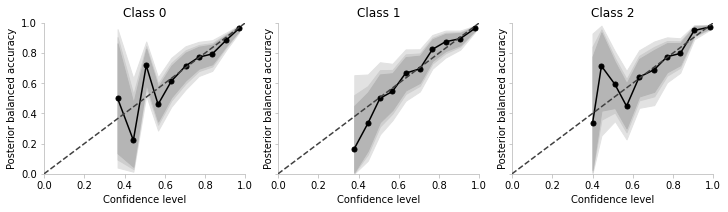

In [ ]:
fig, axes = plt.subplots(1, 3, subplot_kw={"aspect": 0.75}, constrained_layout=True, sharex=True, sharey=True, dpi=72, figsize=(10, 3))
class_wise_posterior_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, axes=axes, bins=15)

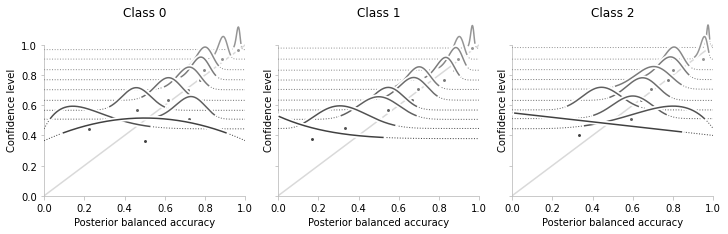

In [ ]:
fig, axes = plt.subplots(1, 3, subplot_kw={"aspect": 0.75}, constrained_layout=True, sharex=True, sharey=True, dpi=72, figsize=(10, 3))
class_wise_posterior_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, axes=axes, bins=15, style="ridge")

Provide an error metric to show the plots ordered according decreasing error.

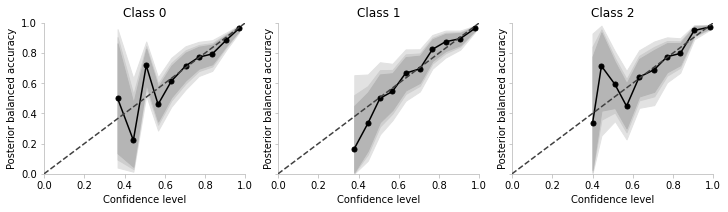

In [ ]:
fig, axes = plt.subplots(1, 3, subplot_kw={"aspect": 0.75}, constrained_layout=True, sharex=True, sharey=True, dpi=72, figsize=(10, 3))
class_wise_posterior_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, axes=axes, bins=15, metric=rmetrics.peace)

## Confidence reliability diagram

In [ ]:
# exporti

def bar_diagram(edges:np.array, bin_accuracies:np.array, bin_confidences:np.array, ax:matplotlib.axes.Axes, bin_sem:np.array=None):
    """Plot a bar plot confidence reliability diagram.

    Arguments:
    edges -- Edges of the probability bins
    bin_accuracies -- Accuracy per bin
    bin_confidences -- Average confidence of predictions in bin
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    """

    _decorate_ax(ax)
    cmap = clipped_cm(len(bin_accuracies), clip_range=(0.2, 0.7))

    ax.plot([0,1], [0,1], linestyle="--", color=cmap(1), alpha=0.3, linewidth=0.75)

    for i, (xi, yi, bi) in enumerate(zip(edges, bin_accuracies, bin_confidences)):
        if np.isnan(bi):
            continue
        if yi < 0:
            continue
        if bin_sem is not None:
            sem = bin_sem[i]
        else:
            sem = 0.

        # plot bin value
        ax.bar(xi, yi, width=edges[1], align="edge", color=cmap(1-bi), edgecolor="grey", yerr=sem, linewidth=1, zorder=0)
        
        # plot gap to ideal value
        ax.bar(
            xi+edges[1]/2, np.abs(bi-yi), bottom=min(bi, yi), width=edges[1], 
            align="center", color=cmap(0), edgecolor="grey", linewidth=1, zorder=1
        )

In [ ]:
# export

def confidence_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, ax:matplotlib.axes.Axes, bins="fd", balanced:bool=True):
    """Plot a confidence reliability diagram.

    Arguments:
    y_probs -- Array containing prediction confidences
    y_preds -- Array containing predicted labels (shape (N,))
    y_true -- Array containing true labels (shape (N,))
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    bins -- Description of amount of bins in which to divide prediction confidences (see `numpy.histogram_bin_edges` for options)
    balanced -- Flag for using balanced accuracy score
    """

    if len(y_probs.shape) == 2:
        if y_probs.shape[1] == 2:
            y_probs = y_probs[:, 0]
        else:
            y_probs = y_probs.max(axis=1)

    bin_indices, edges = utils.get_bin_indices(y_probs, bins, 0.0, 1.0, return_edges=True)
    unique_bin_indices = sorted(np.unique(bin_indices))

    mean_confidences = np.full((len(edges)-1,), dtype=np.float32, fill_value=np.nan)
    bin_metric = np.full((len(edges)-1,), dtype=np.float32, fill_value=np.nan)

    metric = balanced_accuracy_score if balanced else accuracy_score

    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Balanced accuracy" if balanced else "Accuracy")

    for bin_idx in unique_bin_indices:
        selector = bin_indices == bin_idx

        C = confusion_matrix(y_true[selector], y_preds[selector])
        with np.errstate(divide='ignore', invalid='ignore'):
            per_class = np.diag(C) / C.sum(axis=1)
        per_class = per_class[~np.isnan(per_class)]
        if len(per_class) < 2:
            continue

        mean_confidences[bin_idx-1] = np.mean(y_probs[selector])
        bin_metric[bin_idx-1] = metric(y_true[selector], y_preds[selector])

        bar_diagram(edges, bin_metric, mean_confidences, ax)

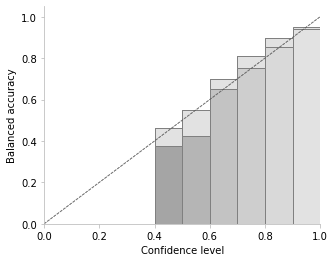

In [ ]:
fig, ax = plt.subplots(subplot_kw={"aspect": 0.75})
confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10)

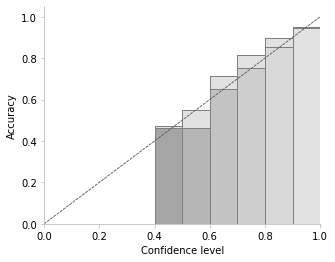

In [ ]:
fig, ax = plt.subplots(subplot_kw={"aspect": 0.75})
confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10, balanced=False)

In [ ]:
# export

def class_wise_confidence_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, axes:matplotlib.axes.Axes, bins="fd", balanced:bool=True):
    """Plot a class-wise confidence reliability diagram.

    Arguments:
    y_probs -- Array containing prediction confidences
    y_preds -- Array containing predicted labels (shape (N,))
    y_true -- Array containing true labels (shape (N,))
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    bins -- Description of amount of bins in which to divide prediction confidences (see `numpy.histogram_bin_edges` for options)
    balanced -- Flag for using balanced accuracy score
    """

    classes = np.unique(y_true)

    y_true_binarized = label_binarize(y_true, classes=classes)
    y_preds_binarized = label_binarize(y_preds, classes=classes)

    for ax, c in zip(axes, range(len(classes))):
        ax.set_title(f"Class {c}")
        probs = np.where(y_preds_binarized[:, c]==0, 1-y_probs[:, c], y_probs[:, c])
        confidence_reliability_diagram(probs, y_preds_binarized[:, c], y_true_binarized[:, c], ax, bins, balanced)

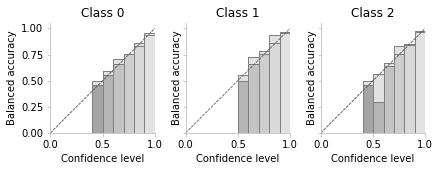

In [ ]:
fig, ax = plt.subplots(1, 3, subplot_kw={"aspect": 1}, constrained_layout=True, sharex=True, sharey=True)
class_wise_confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10)

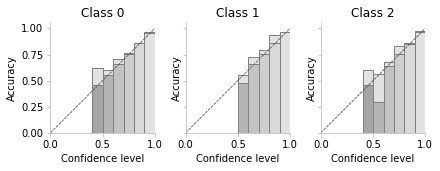

In [ ]:
fig, ax = plt.subplots(1, 3, subplot_kw={"aspect": 1}, constrained_layout=True, sharex=True, sharey=True)
class_wise_confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10, balanced=False)